# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [1]:
import numpy as np
import theano
import theano.tensor as T
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

In [4]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

#print(X_train.shape,y_train.shape)

ModuleNotFoundError: No module named 'mnist'

In [3]:
input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [4]:

import lasagne
from lasagne.layers import *

#Input layer (auxilary)
l0 = InputLayer(shape = input_shape,input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)

l1 = lasagne.layers.ReshapeLayer(l0, (-1,1,28,28))

l2 = lasagne.layers.Conv2DLayer(l1, num_filters=32, filter_size=3, pad=1)

l3 = lasagne.layers.Pool2DLayer(l2, 2)

l4 = lasagne.layers.Conv2DLayer(l3, num_filters=10, filter_size=3, pad=1)

l5 = lasagne.layers.Pool2DLayer(l4, 2)

l6 = DenseLayer(l5,num_units=100,nonlinearity = lasagne.nonlinearities.elu)

l7 = DenseLayer(l6,num_units=100,nonlinearity = lasagne.nonlinearities.elu)

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
l_out = DenseLayer(l7,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)


'''
import lasagne
from lasagne.layers import *

#Input layer (auxilary)
l0 = InputLayer(shape = input_shape,input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)

l1 = lasagne.layers.ReshapeLayer(l0, (-1,1,28,28))

l2 = lasagne.layers.Conv2DLayer(l1, num_filters=10, filter_size=3, pad=1)

l5 = lasagne.layers.Conv2DLayer(l2, num_filters=10, filter_size=3, pad=1)

l6 = DenseLayer(l5,num_units=100,nonlinearity = lasagne.nonlinearities.elu)

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
l_out = DenseLayer(l6,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)
# - 98.8%
'''

'\nimport lasagne\nfrom lasagne.layers import *\n\n#Input layer (auxilary)\nl0 = InputLayer(shape = input_shape,input_var=input_X)\n\n#fully connected layer, that takes input layer and applies 50 neurons to it.\n# nonlinearity here is sigmoid as in logistic regression\n# you can give a name to each layer (optional)\n\nl1 = lasagne.layers.ReshapeLayer(l0, (-1,1,28,28))\n\nl2 = lasagne.layers.Conv2DLayer(l1, num_filters=10, filter_size=3, pad=1)\n\nl5 = lasagne.layers.Conv2DLayer(l2, num_filters=10, filter_size=3, pad=1)\n\nl6 = DenseLayer(l5,num_units=100,nonlinearity = lasagne.nonlinearities.elu)\n\n#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)\n#We use softmax nonlinearity to make probabilities add up to 1\nl_out = DenseLayer(l6,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)\n# - 98.8%\n'

In [5]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(l_out)

In [6]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(l_out)
print (all_weights)

[W, b, W, b, W, b, W, b, W, b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [7]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
n = theano.shared(40)
#b = theano.shared(10)

updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=5/n)

In [8]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [9]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        inputs[excerpt]+=np.random.normal(0,1)/75
        yield inputs[excerpt], targets[excerpt]

# Training loop

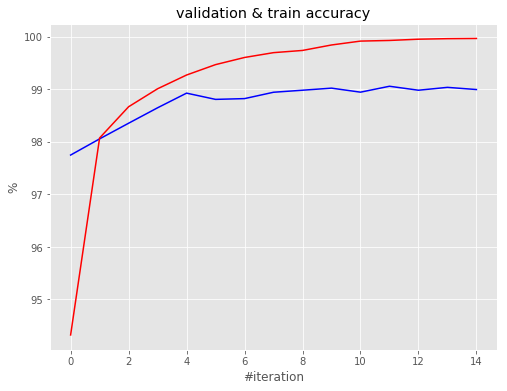

Current train accuracy: 99.969982
Current validation accuracy: 98.997494


In [10]:
import time

num_epochs = 15 #amount of passes through the data

batch_size = 20 #number of samples processed at each function call

p1, p2 = [], []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    
    n=40
    batch_size += 5
    
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        n+=1
        

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

        
    '''
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    
    '''
    
    p1.append(train_acc / train_batches * 100)
    p2.append(val_acc / val_batches * 100)
    
      # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("validation & train accuracy")
    plt.xlabel("#iteration")
    plt.ylabel("%")
    plt.plot(p2, 'b')
    plt.plot(p1, 'r')
    plt.show()
    
    print('Current train accuracy: %f' % p1[-1])
    print('Current validation accuracy: %f' % p2[-1])


In [11]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
  test accuracy:		99.15 %
Achievement unlocked: 80lvl Warlock!
